# Object Detection

In this notebook, we will go through basics of Object Detection and implement YOLOv3

Here we will use [keras](https://keras.io  "Keras Tutorial").


Everything is explained in-detail in [blog post](https://dudeperf3ct.github.io/object/detection/2019/01/07/Mystery-of-Object-Detection/). This is notebook which replicates the result of blog and runs in colab. Enjoy!


#### Run in Colab

You can run this notebook in google colab.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dudeperf3ct/DL_notebooks/blob/master/Object%20Detection/Keras/object_detection_keras.ipynb)

In [0]:
from google.colab import drive

drive.mount('/content/drive')

In [0]:
# !ls "/content/drive/My Drive/Colab Notebooks"

In [0]:
!cp -R "/content/drive/My Drive/Colab Notebooks/yolo" "/content/"
!cp "/content/drive/My Drive/Colab Notebooks/dog.jpg" "yolo/dog.jpg"
!cp "/content/drive/My Drive/Colab Notebooks/horses.jpg" "yolo/horses.jpg"
!cp "/content/drive/My Drive/Colab Notebooks/person.jpg" "yolo/person.jpg"
!cp "/content/drive/My Drive/Colab Notebooks/chimps.jpg" "yolo/chimps.jpg"
!cp "/content/drive/My Drive/Colab Notebooks/ellen.jpg" "yolo/ellen.jpg"
!cp "/content/drive/My Drive/Colab Notebooks/selfie.jpg" "yolo/selfie.jpg"
!cp "/content/drive/My Drive/Colab Notebooks/beach.jpg" "yolo/beach.jpg"
!cp "/content/drive/My Drive/Colab Notebooks/two_dogs.jpg" "yolo/two_dogs.jpg"

## Data preprocessing

We will be looking at the [Pascal VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/). It's quite slow, so you may prefer to download from this [mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this)

In [0]:
!wget https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
#!wget https://pjreddie.com/media/files/VOCtest_06-Nov-2007.tar
!tar xf VOCtrainval_06-Nov-2007.tar
#!tar xf VOCtest_06-Nov-2007.tar

--2019-02-02 01:40:16--  https://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/octet-stream]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  58.4MB/s    in 7.7s    

2019-02-02 01:40:24 (57.2 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]



As well as the images, there are also annotations - bounding boxes showing where each object is. These were hand labeled. The original version were in XML, which is a little hard to work with nowadays, so we uses the more recent JSON version which you can download from this [link](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip).


In [0]:
# ! wget 'https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip'
# ! unzip 'PASCAL_VOC.zip'

### YOLO v3 preprocessing

In [0]:
from pathlib import Path
path = Path('yolo')

! wget 'https://pjreddie.com/media/files/yolov3.weights' -P {path}

--2019-02-02 01:40:30--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.3.39
Connecting to pjreddie.com (pjreddie.com)|128.208.3.39|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolo/yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  40.0MB/s    in 6.2s    

2019-02-02 01:40:36 (38.4 MB/s) - ‘yolo/yolov3.weights’ saved [248007048/248007048]



In [0]:
#! /usr/bin/env python
"""
Reads Darknet config and weights and creates Keras model with TF backend.

"""
import configparser
import io
import os
from collections import defaultdict

import numpy as np
from keras import backend as K
from keras.layers import (Conv2D, Input, ZeroPadding2D, Add,
                          UpSampling2D, MaxPooling2D, Concatenate)
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.models import Model
from keras.regularizers import l2
from keras.utils.vis_utils import plot_model as plot


config_path = path/'yolov3.cfg'
weights_path = path/'yolov3.weights'
output_path = path/'yolov3.h5'

def unique_config_sections(config_file):
    """Convert all config sections to have unique names.

    Adds unique suffixes to config sections for compability with configparser.
    """
    section_counters = defaultdict(int)
    output_stream = io.StringIO()
    with open(config_file) as fin:
        for line in fin:
            if line.startswith('['):
                section = line.strip().strip('[]')
                _section = section + '_' + str(section_counters[section])
                section_counters[section] += 1
                line = line.replace(section, _section)
            output_stream.write(line)
    output_stream.seek(0)
    return output_stream

config_path = os.path.expanduser(config_path)
weights_path = os.path.expanduser(weights_path)
assert config_path.endswith('.cfg'), '{} is not a .cfg file'.format(
    config_path)
assert weights_path.endswith(
    '.weights'), '{} is not a .weights file'.format(weights_path)

output_path = os.path.expanduser(output_path)
assert output_path.endswith(
    '.h5'), 'output path {} is not a .h5 file'.format(output_path)
output_root = os.path.splitext(output_path)[0]

# Load weights and config.
print('Loading weights.')
weights_file = open(weights_path, 'rb')
major, minor, revision = np.ndarray(
    shape=(3, ), dtype='int32', buffer=weights_file.read(12))
if (major*10+minor)>=2 and major<1000 and minor<1000:
    seen = np.ndarray(shape=(1,), dtype='int64', buffer=weights_file.read(8))
else:
    seen = np.ndarray(shape=(1,), dtype='int32', buffer=weights_file.read(4))
print('Weights Header: ', major, minor, revision, seen)

print('Parsing Darknet config.')
unique_config_file = unique_config_sections(config_path)
cfg_parser = configparser.ConfigParser()
cfg_parser.read_file(unique_config_file)

print('Creating Keras model.')
input_layer = Input(shape=(None, None, 3))
prev_layer = input_layer
all_layers = []

weight_decay = float(cfg_parser['net_0']['decay']
                     ) if 'net_0' in cfg_parser.sections() else 5e-4
count = 0
out_index = []
for section in cfg_parser.sections():
    print('Parsing section {}'.format(section))
    if section.startswith('convolutional'):
        filters = int(cfg_parser[section]['filters'])
        size = int(cfg_parser[section]['size'])
        stride = int(cfg_parser[section]['stride'])
        pad = int(cfg_parser[section]['pad'])
        activation = cfg_parser[section]['activation']
        batch_normalize = 'batch_normalize' in cfg_parser[section]

        padding = 'same' if pad == 1 and stride == 1 else 'valid'

        # Setting weights.
        # Darknet serializes convolutional weights as:
        # [bias/beta, [gamma, mean, variance], conv_weights]
        prev_layer_shape = K.int_shape(prev_layer)

        weights_shape = (size, size, prev_layer_shape[-1], filters)
        darknet_w_shape = (filters, weights_shape[2], size, size)
        weights_size = np.product(weights_shape)

        print('conv2d', 'bn'
              if batch_normalize else '  ', activation, weights_shape)

        conv_bias = np.ndarray(
            shape=(filters, ),
            dtype='float32',
            buffer=weights_file.read(filters * 4))
        count += filters

        if batch_normalize:
            bn_weights = np.ndarray(
                shape=(3, filters),
                dtype='float32',
                buffer=weights_file.read(filters * 12))
            count += 3 * filters

            bn_weight_list = [
                bn_weights[0],  # scale gamma
                conv_bias,  # shift beta
                bn_weights[1],  # running mean
                bn_weights[2]  # running var
            ]

        conv_weights = np.ndarray(
            shape=darknet_w_shape,
            dtype='float32',
            buffer=weights_file.read(weights_size * 4))
        count += weights_size

        # DarkNet conv_weights are serialized Caffe-style:
        # (out_dim, in_dim, height, width)
        # We would like to set these to Tensorflow order:
        # (height, width, in_dim, out_dim)
        conv_weights = np.transpose(conv_weights, [2, 3, 1, 0])
        conv_weights = [conv_weights] if batch_normalize else [
            conv_weights, conv_bias
        ]

        # Handle activation.
        act_fn = None
        if activation == 'leaky':
            pass  # Add advanced activation later.
        elif activation != 'linear':
            raise ValueError(
                'Unknown activation function `{}` in section {}'.format(
                    activation, section))

        # Create Conv2D layer
        if stride>1:
            # Darknet uses left and top padding instead of 'same' mode
            prev_layer = ZeroPadding2D(((1,0),(1,0)))(prev_layer)
        conv_layer = (Conv2D(
            filters, (size, size),
            strides=(stride, stride),
            kernel_regularizer=l2(weight_decay),
            use_bias=not batch_normalize,
            weights=conv_weights,
            activation=act_fn,
            padding=padding))(prev_layer)

        if batch_normalize:
            conv_layer = (BatchNormalization(
                weights=bn_weight_list))(conv_layer)
        prev_layer = conv_layer

        if activation == 'linear':
            all_layers.append(prev_layer)
        elif activation == 'leaky':
            act_layer = LeakyReLU(alpha=0.1)(prev_layer)
            prev_layer = act_layer
            all_layers.append(act_layer)

    elif section.startswith('route'):
        ids = [int(i) for i in cfg_parser[section]['layers'].split(',')]
        layers = [all_layers[i] for i in ids]
        if len(layers) > 1:
            print('Concatenating route layers:', layers)
            concatenate_layer = Concatenate()(layers)
            all_layers.append(concatenate_layer)
            prev_layer = concatenate_layer
        else:
            skip_layer = layers[0]  # only one layer to route
            all_layers.append(skip_layer)
            prev_layer = skip_layer

    elif section.startswith('maxpool'):
        size = int(cfg_parser[section]['size'])
        stride = int(cfg_parser[section]['stride'])
        all_layers.append(
            MaxPooling2D(
                pool_size=(size, size),
                strides=(stride, stride),
                padding='same')(prev_layer))
        prev_layer = all_layers[-1]

    elif section.startswith('shortcut'):
        index = int(cfg_parser[section]['from'])
        activation = cfg_parser[section]['activation']
        assert activation == 'linear', 'Only linear activation supported.'
        all_layers.append(Add()([all_layers[index], prev_layer]))
        prev_layer = all_layers[-1]

    elif section.startswith('upsample'):
        stride = int(cfg_parser[section]['stride'])
        assert stride == 2, 'Only stride=2 supported.'
        all_layers.append(UpSampling2D(stride)(prev_layer))
        prev_layer = all_layers[-1]

    elif section.startswith('yolo'):
        out_index.append(len(all_layers)-1)
        all_layers.append(None)
        prev_layer = all_layers[-1]

    elif section.startswith('net'):
        pass

    else:
        raise ValueError(
            'Unsupported section header type: {}'.format(section))

# Create and save model.
if len(out_index)==0: out_index.append(len(all_layers)-1)
model = Model(inputs=input_layer, outputs=[all_layers[i] for i in out_index])
print(model.summary())

# model.save_weights('{}'.format(output_path))
# print('Saved Keras weights to {}'.format(output_path))

model.save('{}'.format(output_path))
print('Saved Keras model to {}'.format(output_path))

# Check to see if all weights have been read.
remaining_weights = len(weights_file.read()) / 4
weights_file.close()
print('Read {} of {} from Darknet weights.'.format(count, count +
                                                   remaining_weights))
if remaining_weights > 0:
    print('Warning: {} unused weights'.format(remaining_weights))

Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)
Parsing section convolutional_1
conv2d bn leaky (3, 3, 32, 64)
Parsing section convolutional_2
conv2d bn leaky (1, 1, 64, 32)
Parsing section convolutional_3
conv2d bn leaky (3, 3, 32, 64)
Parsing section shortcut_0
Parsing section convolutional_4
conv2d bn leaky (3, 3, 64, 128)
Parsing section convolutional_5
conv2d bn leaky (1, 1, 128, 64)
Parsing section convolutional_6
conv2d bn leaky (3, 3, 64, 128)
Parsing section shortcut_1
Parsing section convolutional_7
conv2d bn leaky (1, 1, 128, 64)
Parsing section convolutional_8
conv2d bn leaky (3, 3, 64, 128)
Parsing section shortcut_2
Parsing section convolutional_9
conv2d bn leaky (3, 3, 128, 256)
Parsing section convolutional_10
conv2d bn leaky (1, 1, 256, 128)
Parsing section convolutional_11
conv2d bn leaky (3, 3, 128, 256)
Parsing section shortcut_3
Parsi

In [0]:
import xml.etree.ElementTree as ET
from os import getcwd

sets=[('2007', 'train'), ('2007', 'val')]

classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat", "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person", "pottedplant", "sheep", "sofa", "train", "tvmonitor"]


def convert_annotation(year, image_id, list_file):
    in_file = open('VOCdevkit/VOC%s/Annotations/%s.xml'%(year, image_id))
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text), int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

wd = getcwd()

for year, image_set in sets:
    image_ids = open('VOCdevkit/VOC%s/ImageSets/Main/%s.txt'%(year, image_set)).read().strip().split()
    list_file = open('%s_%s.txt'%(year, image_set), 'w')
    for image_id in image_ids:
        list_file.write('%s/VOCdevkit/VOC%s/JPEGImages/%s.jpg'%(wd, year, image_id))
        convert_annotation(year, image_id, list_file)
        list_file.write('\n')
    list_file.close()

#os.system("cat 2007_train.txt 2007_val.txt > train.txt")

## Multi Label classification preprocessing

In [0]:
from pathlib import Path
import pandas as pd
import numpy as np
import collections
import json
from PIL import ImageDraw, ImageFont, Image
from matplotlib import patches, patheffects
import matplotlib.pyplot as plt

%matplotlib inline

IMG_PATH = Path('VOCdevkit/VOC2007/JPEGImages')

In [0]:
path = Path('PASCAL_VOC')
trn = json.load((path/'pascal_train2007.json').open())
trn.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [0]:
img, anno, cat = ['images', 'annotations', 'categories']
trn[img][:3], trn[anno][:3], trn[cat][:3]

([{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
  {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
  {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334}],
 [{'area': 34104,
   'bbox': [155, 96, 196, 174],
   'category_id': 7,
   'id': 1,
   'ignore': 0,
   'image_id': 12,
   'iscrowd': 0,
   'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
  {'area': 13110,
   'bbox': [184, 61, 95, 138],
   'category_id': 15,
   'id': 2,
   'ignore': 0,
   'image_id': 17,
   'iscrowd': 0,
   'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]},
  {'area': 81326,
   'bbox': [89, 77, 314, 259],
   'category_id': 13,
   'id': 3,
   'ignore': 0,
   'image_id': 17,
   'iscrowd': 0,
   'segmentation': [[89, 77, 89, 336, 403, 336, 403, 77]]}],
 [{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
  {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
  {'id': 3, 'name': 'bird', 'supercategory': 'none'}])

In [0]:
file_name, ID, img_id, cat_id, bbox = 'file_name','id','image_id','category_id','bbox'

cats = dict((o[ID], o['name']) for o in trn[cat])
trn_fns = dict((o[ID], o[file_name]) for o in trn[img])
trn_ids = [o[ID] for o in trn[img]]

In [0]:
def get_trn_anno():
    trn_anno = collections.defaultdict(lambda:[])
    for o in trn[anno]:
        if not o['ignore']:
            bb = o[bbox]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            trn_anno[o[img_id]].append((bb,o[cat_id]))
    return trn_anno

trn_anno = get_trn_anno()

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.linspace(0, 224, 8))
    ax.set_yticks(np.linspace(0, 224, 8))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [0]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

def draw_idx(i):
    im_a = trn_anno[i]
    im = Image.open(IMG_PATH/trn_fns[i])
    print (im.size)
    draw_im(im, im_a)

(500, 281)


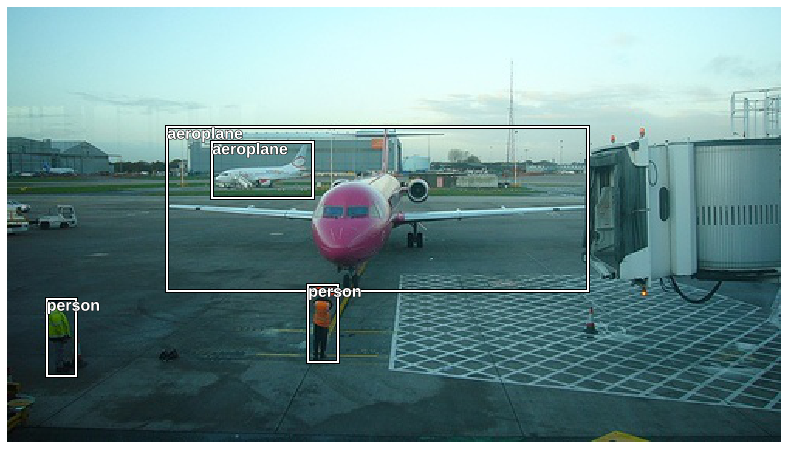

In [0]:
draw_idx(32)

(500, 366)


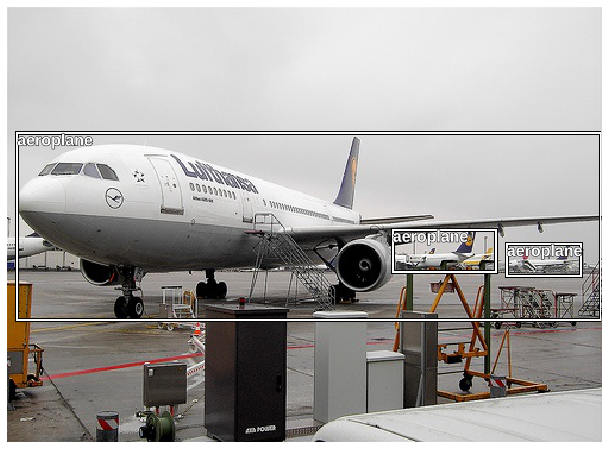

In [0]:
draw_idx(33)

(500, 335)


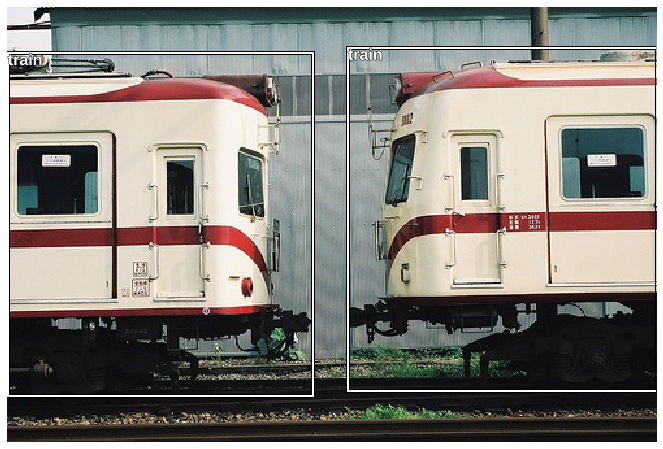

In [0]:
draw_idx(42)

(332, 500)


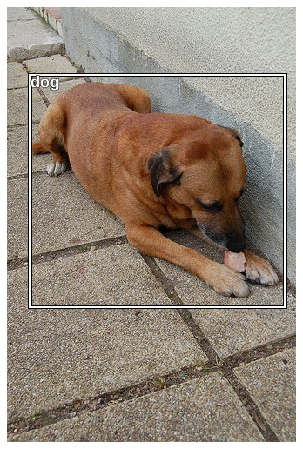

In [0]:
draw_idx(36)

## Multi Label Classification

In [0]:
import keras
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.applications.densenet import DenseNet121, DenseNet201
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from tqdm import tqdm
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

from IPython.display import display

In [0]:
mc = [set([p[1] for p in trn_anno[o]]) for o in trn_ids]

In [0]:
mlb = MultiLabelBinarizer()

In [0]:
mlb.fit(mc)

MultiLabelBinarizer(classes=None, sparse_output=False)

In [0]:
mlb.classes_

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [0]:
mlb.transform([(13, 15)])

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0]])

In [0]:
trn_labels = mlb.transform(mc)
trn_labels.shape

(2501, 20)

In [0]:
df = pd.DataFrame({'fn': [IMG_PATH/trn_fns[o] for o in trn_ids], 'class': [o for o in trn_labels]}, columns=['fn','class'])
df.to_csv('pascal_voc2007_train_classes.csv', index=False)

In [0]:
display(df.head())
print (df.shape)

,fn,class
0,VOCdevkit/VOC2007/JPEGImages/000012.jpg,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,VOCdevkit/VOC2007/JPEGImages/000017.jpg,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, ..."
2,VOCdevkit/VOC2007/JPEGImages/000023.jpg,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
3,VOCdevkit/VOC2007/JPEGImages/000026.jpg,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,VOCdevkit/VOC2007/JPEGImages/000032.jpg,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


(2501, 2)


In [0]:
(train_X, val_X, train_Y, val_Y) = train_test_split(df['fn'], trn_labels, test_size=0.1, random_state=42)
print ('Training shape:', train_X.shape, train_Y.shape)
print ('Validation shape:', val_X.shape, val_Y.shape)

Training shape: (2250,) (2250, 20)
Validation shape: (251,) (251, 20)


In [0]:
cats

{1: 'aeroplane',
 2: 'bicycle',
 3: 'bird',
 4: 'boat',
 5: 'bottle',
 6: 'bus',
 7: 'car',
 8: 'cat',
 9: 'chair',
 10: 'cow',
 11: 'diningtable',
 12: 'dog',
 13: 'horse',
 14: 'motorbike',
 15: 'person',
 16: 'pottedplant',
 17: 'sheep',
 18: 'sofa',
 19: 'train',
 20: 'tvmonitor'}

In [0]:
def preprocess_image(data, labels):
    arr = []
    tar = []
    for i, img_path in enumerate(tqdm(data)):
        x = load_img(data.iloc[i], target_size=(224, 224))
        x = img_to_array(x)
        x = preprocess_input(x)
        arr.append(x)
        tar.append(labels[i])
    return np.array(arr), np.array(tar)
  
train_x, train_y = preprocess_image(train_X, train_Y)  
val_x, val_y = preprocess_image(val_X, val_Y)  

print ('Training shape:', train_x.shape, train_y.shape)
print ('Validation shape:', val_x.shape, val_y.shape)

100%|██████████| 251/251 [00:01<00:00, 192.01it/s]


Training shape: (2250, 224, 224, 3) (2250, 20)
Validation shape: (251, 224, 224, 3) (251, 20)


In [0]:
batch_size = 32
epochs = 10
num_classes = 20
learning_rate = 1e-3

base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))

x = Dense(256, activation='relu')(base_model.output) 
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

opt = Adam(lr = learning_rate, decay = learning_rate / epochs)
model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])

filepath = 'model-{epoch:02d}-{val_loss:.2f}.hdf5'
mc = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True)
es = EarlyStopping(monitor = 'val_acc', patience = 3)

In [0]:
history = model.fit(train_x, train_y,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_data=(val_x, val_y),
                    callbacks=[mc, es])

Train on 2250 samples, validate on 251 samples
Epoch 1/10
2250/2250 [==============================] - 85s 38ms/step - loss: 0.2533 - acc: 0.9198 - val_loss: 0.9292 - val_acc: 0.9245

Epoch 00001: val_acc improved from -inf to 0.92450, saving model to model-01-0.93.hdf5
Epoch 2/10
2250/2250 [==============================] - 64s 28ms/step - loss: 0.1979 - acc: 0.9341 - val_loss: 0.3595 - val_acc: 0.9275

Epoch 00002: val_acc improved from 0.92450 to 0.92749, saving model to model-02-0.36.hdf5
Epoch 3/10
2250/2250 [==============================] - 64s 28ms/step - loss: 0.1705 - acc: 0.9419 - val_loss: 0.3247 - val_acc: 0.9169

Epoch 00003: val_acc did not improve from 0.92749
Epoch 4/10
2250/2250 [==============================] - 64s 28ms/step - loss: 0.1480 - acc: 0.9478 - val_loss: 0.3297 - val_acc: 0.9141

Epoch 00004: val_acc did not improve from 0.92749
Epoch 5/10
2250/2250 [==============================] - 64s 28ms/step - loss: 0.1278 - acc: 0.9544 - val_loss: 0.2410 - val_acc:

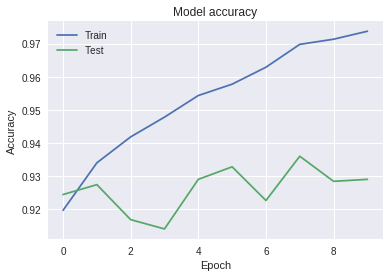

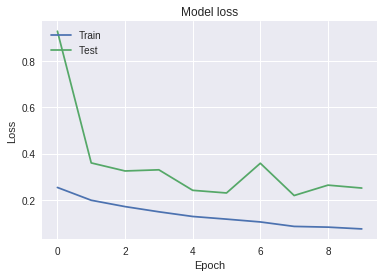

In [0]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model = load_model('model-08-0.22.hdf5')

[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]
[[0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0]]
Actual Output: ['motorbike', 'person']
Predicted Output: ['motorbike', 'person']


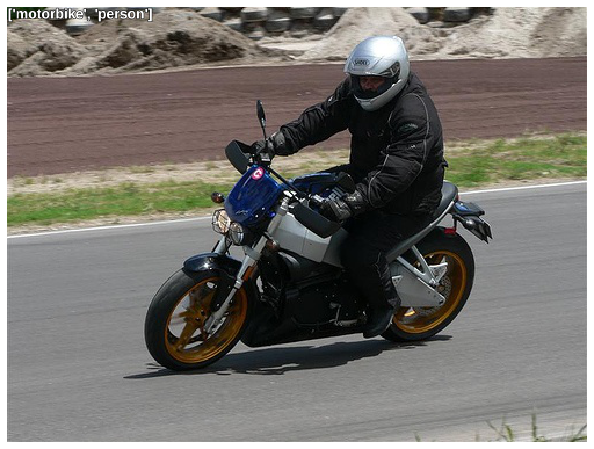

In [0]:
def preprocess(img_path):
      x = load_img(img_path, target_size=(224, 224))
      x = img_to_array(x)
      x = x[None]
      x = preprocess_input(x)
      return x

num = np.random.randint(low=0, high=val_X.shape[0])
img = val_X.iloc[num]
lbls  = (val_Y[num])
print (lbls)

preds = model.predict(preprocess(img))
#print (preds)
preds = (preds>0.4).astype('int')
print (preds)

label = mlb.inverse_transform(lbls.reshape(1, 20))
print ('Actual Output:', [cats[o] for o in label[0]])


pred_label = mlb.inverse_transform(preds.reshape(1, 20))
print ('Predicted Output:', [cats[o] for o in pred_label[0]])

ax = show_img(Image.open(img), figsize=(12, 8))
draw_text(ax, (0,0), [cats[o] for o in pred_label[0]])

## YOLO V3

Very cool paper :

Code Adapted :  [Link](https://github.com/qqwweee/keras-yolo3)

In [0]:
import numpy as np
import time
import keras.backend as K
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.layers import Input, Lambda
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from PIL import Image
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
%matplotlib inline

from yolo.model import preprocess_true_boxes, yolo_body, yolo_loss
from yolo.utils import get_random_data, draw_boxes, get_colors_for_classes

Using TensorFlow backend.


In [0]:
def get_classes(classes_path):
    '''loads the classes'''
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

def get_anchors(anchors_path):
    '''loads the anchors from a file'''
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape(-1, 2)

In [0]:
def create_model(input_shape, anchors, num_classes, load_pretrained=True, freeze_body=2,
            weights_path='yolo/yolov3_weights.h5'):
    '''create the training model'''
    K.clear_session() # get a new session
    image_input = Input(shape=(None, None, 3))
    h, w = input_shape
    num_anchors = len(anchors)

    y_true = [Input(shape=(h//{0:32, 1:16, 2:8}[l], w//{0:32, 1:16, 2:8}[l], \
        num_anchors//3, num_classes+5)) for l in range(3)]

    model_body = yolo_body(image_input, num_anchors//3, num_classes)
    print('Create YOLOv3 model with {} anchors and {} classes.'.format(num_anchors, num_classes))

    if load_pretrained:
        model_body.load_weights(weights_path, by_name=True, skip_mismatch=True)
        print('Load weights {}.'.format(weights_path))
        if freeze_body in [1, 2]:
            # Freeze darknet53 body or freeze all but 3 output layers.
            num = (185, len(model_body.layers)-3)[freeze_body-1]
            for i in range(num): model_body.layers[i].trainable = False
            print('Freeze the first {} layers of total {} layers.'.format(num, len(model_body.layers)))

    model_loss = Lambda(yolo_loss, output_shape=(1,), name='yolo_loss',
        arguments={'anchors': anchors, 'num_classes': num_classes, 'ignore_thresh': 0.5})(
        [*model_body.output, *y_true])
    model = Model([model_body.input, *y_true], model_loss)

    return model

In [0]:
def data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes):
    '''data generator for fit_generator'''
    n = len(annotation_lines)
    i = 0
    while True:
        image_data = []
        box_data = []
        for b in range(batch_size):
            if i==0:
                np.random.shuffle(annotation_lines)
            image, box = get_random_data(annotation_lines[i], input_shape, random=True)
            image_data.append(image)
            box_data.append(box)
            i = (i+1) % n
        image_data = np.array(image_data)
        box_data = np.array(box_data)
        y_true = preprocess_true_boxes(box_data, input_shape, anchors, num_classes)
        yield [image_data, *y_true], np.zeros(batch_size)

def data_generator_wrapper(annotation_lines, batch_size, input_shape, anchors, num_classes):
    n = len(annotation_lines)
    if n==0 or batch_size<=0: return None
    return data_generator(annotation_lines, batch_size, input_shape, anchors, num_classes)

### Training

In [0]:
# annotation_path = '2007_train.txt'
# log_dir = 'yolo/logs/'
# classes_path = 'yolo/voc_classes.txt'
# anchors_path = 'yolo/yolo_anchors.txt'
# class_names = get_classes(classes_path)
# num_classes = len(class_names)
# anchors = get_anchors(anchors_path)

# input_shape = (416, 416)  # multiple of 32, hw

# model = create_model(input_shape, anchors, num_classes,
#                      freeze_body=2, weights_path='yolo/yolov3_weights.h5') # make sure you know what you freeze

# logging = TensorBoard(log_dir=log_dir)
# checkpoint = ModelCheckpoint(log_dir + 'ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
#     monitor='val_loss', save_weights_only=True, save_best_only=True, period=3)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
# early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# val_split = 0.1
# with open(annotation_path) as f:
#     lines = f.readlines()
# np.random.seed(10101)
# np.random.shuffle(lines)
# np.random.seed(None)
# num_val = int(len(lines)*val_split)
# num_train = len(lines) - num_val

# # # Train with frozen layers first, to get a stable loss.
# # # Adjust num epochs to your dataset. This step is enough to obtain a not bad model.
# # if True:
# #     model.compile(optimizer=Adam(lr=1e-3), loss={
# #         # use custom yolo_loss Lambda layer.
# #         'yolo_loss': lambda y_true, y_pred: y_pred})

# #     batch_size = 32
# #     print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
# #     model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
# #             steps_per_epoch=max(1, num_train//batch_size),
# #             validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
# #             validation_steps=max(1, num_val//batch_size),
# #             epochs=50,
# #             initial_epoch=0,
# #             callbacks=[logging, checkpoint])
# #     model.save_weights(log_dir + 'trained_weights_stage_1.h5')
    

# # Unfreeze and continue training, to fine-tune.
# # Train longer if the result is not good.
# if True:
#     for i in range(len(model.layers)):
#         model.layers[i].trainable = True
#     model.compile(optimizer=Adam(lr=1e-4), loss={'yolo_loss': lambda y_true, y_pred: y_pred}) # recompile to apply the change
#     print('Unfreeze all of the layers.')

#     batch_size = 10 # note that more GPU memory is required after unfreezing the body
#     print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
#     model.fit_generator(data_generator_wrapper(lines[:num_train], batch_size, input_shape, anchors, num_classes),
#         steps_per_epoch=max(1, num_train//batch_size),
#         validation_data=data_generator_wrapper(lines[num_train:], batch_size, input_shape, anchors, num_classes),
#         validation_steps=max(1, num_val//batch_size),
#         epochs=25,
#         callbacks=[logging, checkpoint, reduce_lr, early_stopping])
#     model.save_weights(log_dir + 'trained_weights_final.h5')

#     #Further training if needed.
    
#     model.save(log_dir + 'yolov3.h5')

### Inference

In [0]:
import tensorflow as tf
def yolo_head(feats, anchors, num_classes, input_shape, calc_loss=False):
    """Convert final layer features to bounding box parameters."""
    num_anchors = len(anchors)
    # Reshape to batch, height, width, num_anchors, box_params.
    anchors_tensor = K.reshape(K.constant(anchors), [1, 1, 1, num_anchors, 2])

    grid_shape = K.shape(feats)[1:3] # height, width
    grid_y = K.tile(K.reshape(K.arange(0, stop=grid_shape[0]), [-1, 1, 1, 1]),
        [1, grid_shape[1], 1, 1])
    grid_x = K.tile(K.reshape(K.arange(0, stop=grid_shape[1]), [1, -1, 1, 1]),
        [grid_shape[0], 1, 1, 1])
    grid = K.concatenate([grid_x, grid_y])
    grid = K.cast(grid, K.dtype(feats[0]))

    feats = K.reshape(
        feats, [-1, grid_shape[0], grid_shape[1], num_anchors, num_classes + 5])

    # Adjust preditions to each spatial grid point and anchor size.
    box_xy = (K.sigmoid(feats[..., :2]) + grid) / K.cast(grid_shape[::-1], K.dtype(feats))
    box_wh = K.exp(feats[..., 2:4]) * anchors_tensor / K.cast(input_shape[::-1], K.dtype(feats))
    box_confidence = K.sigmoid(feats[..., 4:5])
    box_class_probs = K.sigmoid(feats[..., 5:])

    if calc_loss == True:
        return grid, feats, box_xy, box_wh
    return box_xy, box_wh, box_confidence, box_class_probs

def yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape):
    '''Get corrected boxes'''
    box_yx = box_xy[..., ::-1]
    box_hw = box_wh[..., ::-1]
    input_shape = K.cast(input_shape, K.dtype(box_yx))
    image_shape = K.cast(image_shape, K.dtype(box_yx))
    new_shape = K.round(image_shape * K.min(input_shape/image_shape))
    offset = (input_shape-new_shape)/2./input_shape
    scale = input_shape/new_shape
    box_yx = (box_yx - offset) * scale
    box_hw *= scale

    box_mins = box_yx - (box_hw / 2.)
    box_maxes = box_yx + (box_hw / 2.)
    boxes =  K.concatenate([
        box_mins[..., 0:1],  # y_min
        box_mins[..., 1:2],  # x_min
        box_maxes[..., 0:1],  # y_max
        box_maxes[..., 1:2]  # x_max
    ])

    # Scale boxes back to original image shape.
    boxes *= K.concatenate([image_shape, image_shape])
    return boxes


def yolo_boxes_and_scores(feats, anchors, num_classes, input_shape, image_shape):
    '''Process Conv layer output'''
    box_xy, box_wh, box_confidence, box_class_probs = yolo_head(feats,
        anchors, num_classes, input_shape)
    boxes = yolo_correct_boxes(box_xy, box_wh, input_shape, image_shape)
    boxes = K.reshape(boxes, [-1, 4])
    box_scores = box_confidence * box_class_probs
    box_scores = K.reshape(box_scores, [-1, num_classes])
    return boxes, box_scores


def yolo_eval(yolo_outputs,
              anchors,
              num_classes,
              image_shape,
              max_boxes=20,
              score_threshold=.6,
              iou_threshold=.5):
    """Evaluate YOLO model on given input and return filtered boxes."""
    num_layers = len(yolo_outputs)
    anchor_mask = [[6,7,8], [3,4,5], [0,1,2]] if num_layers==3 else [[3,4,5], [1,2,3]] # default setting
    input_shape = K.shape(yolo_outputs[0])[1:3] * 32
    boxes = []
    box_scores = []
    for l in range(num_layers):
        _boxes, _box_scores = yolo_boxes_and_scores(yolo_outputs[l],
            anchors[anchor_mask[l]], num_classes, input_shape, image_shape)
        boxes.append(_boxes)
        box_scores.append(_box_scores)
    boxes = K.concatenate(boxes, axis=0)
    box_scores = K.concatenate(box_scores, axis=0)

    mask = box_scores >= score_threshold
    max_boxes_tensor = K.constant(max_boxes, dtype='int32')
    boxes_ = []
    scores_ = []
    classes_ = []
    for c in range(num_classes):
        # TODO: use keras backend instead of tf.
        class_boxes = tf.boolean_mask(boxes, mask[:, c])
        class_box_scores = tf.boolean_mask(box_scores[:, c], mask[:, c])
        nms_index = tf.image.non_max_suppression(
            class_boxes, class_box_scores, max_boxes_tensor, iou_threshold=iou_threshold)
        class_boxes = K.gather(class_boxes, nms_index)
        class_box_scores = K.gather(class_box_scores, nms_index)
        classes = K.ones_like(class_box_scores, 'int32') * c
        boxes_.append(class_boxes)
        scores_.append(class_box_scores)
        classes_.append(classes)
    boxes_ = K.concatenate(boxes_, axis=0)
    scores_ = K.concatenate(scores_, axis=0)
    classes_ = K.concatenate(classes_, axis=0)

    return boxes_, scores_, classes_


In [0]:
sess = K.get_session()

classes_path = 'yolo/voc_classes.txt'
anchors_path = 'yolo/yolo_anchors.txt'
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors = get_anchors(anchors_path)
num_anchors = len(anchors)
input_shape=(416, 416)

In [0]:
yolo_model = yolo_body(Input(shape=(None, None, 3)), num_anchors//3, num_classes)
yolo_model.load_weights('yolo/trained_weights_final.h5')

Instructions for updating:
Colocations handled automatically by placer.


In [0]:
yolo_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
zero_paddi

In [0]:
def preprocess_image(image_path):    
    image = Image.open(image_path)
    new_image_size = (image.width - (image.width % 32),
                            image.height - (image.height % 32))
    resized_image = image.resize(new_image_size, Image.BICUBIC)
    image_data = np.array(resized_image, dtype='float32')

    image_data /= 255.
    image_data = np.expand_dims(image_data, 0) # Add batch dimension.

    return image_data, image

In [0]:
def predict(sess, image_path):
    
    start_time = time.time()
  
    image_data, image = preprocess_image(image_path)
    
    image_shape = image_data.shape[1:3]
    
    boxes, scores, classes = yolo_eval(yolo_model.output, anchors, num_classes, image_shape)

    out_boxes, out_scores, out_classes = sess.run([boxes, scores, classes], 
                                                  feed_dict={yolo_model.input:image_data,
                                                             K.learning_phase(): 0})
    print ("Time taken:", time.time()-start_time, "sec")
    print('Found {} boxes for {}'.format(len(out_boxes), image_path.split("/")[1]))
    
    colors = get_colors_for_classes(num_classes)

    draw_boxes(image, out_boxes, out_classes, class_names, out_scores)

    output_path = "output_"+ str(image_path.split("/")[1])+ ".jpg"
    image.save(output_path, quality=90)

    output_image = Image.open(output_path)
    
    plt.grid(visible=False)
    plt.xticks([])
    plt.yticks([])
    imshow(output_image)

Time taken: 5.493067741394043 sec
Found 3 boxes for dog.jpg
bicycle 1.00 (136, 112) (603, 424)
car 0.98 (474, 86) (686, 175)
dog 1.00 (137, 221) (322, 530)


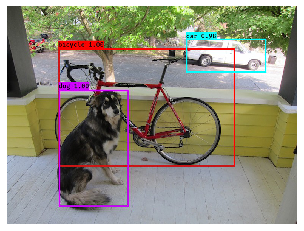

In [0]:
predict(sess, "yolo/dog.jpg")

Time taken: 4.002102851867676 sec
Found 9 boxes for ellen.jpg
person 1.00 (412, 38) (573, 313)
person 1.00 (98, 104) (303, 315)
person 1.00 (194, 104) (552, 321)
person 0.99 (0, 8) (169, 325)
person 0.93 (177, 8) (286, 107)
person 0.88 (135, 7) (198, 103)
person 0.79 (313, 4) (431, 164)
person 0.67 (261, 20) (327, 155)
person 0.66 (397, 30) (447, 81)


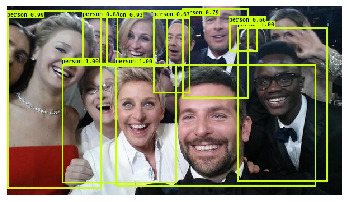

In [0]:
predict(sess, 'yolo/ellen.jpg')

Time taken: 10.440852165222168 sec
Found 20 boxes for selfie.jpg
person 1.00 (1029, 770) (1364, 1111)
person 1.00 (709, 732) (1052, 1105)
person 1.00 (105, 878) (310, 1119)
person 0.99 (1778, 848) (2044, 1119)
person 0.99 (1, 817) (169, 1117)
person 0.99 (511, 865) (660, 1095)
person 0.98 (153, 706) (273, 918)
person 0.97 (298, 853) (451, 1093)
person 0.97 (462, 1020) (650, 1124)
person 0.97 (170, 494) (315, 641)
person 0.96 (1946, 573) (2047, 873)
person 0.96 (1372, 720) (1672, 1103)
person 0.96 (989, 779) (1096, 980)
person 0.94 (1643, 847) (1846, 1106)
person 0.94 (1775, 492) (1817, 550)
person 0.94 (615, 760) (757, 939)
person 0.93 (1771, 604) (1897, 697)
person 0.91 (677, 397) (719, 449)
person 0.90 (474, 666) (649, 827)
person 0.90 (1762, 676) (1906, 776)


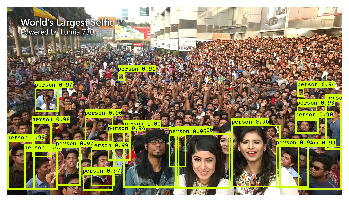

In [0]:
predict(sess, 'yolo/selfie.jpg')

Time taken: 4.978217363357544 sec
Found 3 boxes for horses.jpg
cow 0.86 (415, 217) (602, 345)
horse 1.00 (34, 200) (301, 403)
horse 0.75 (203, 186) (427, 367)


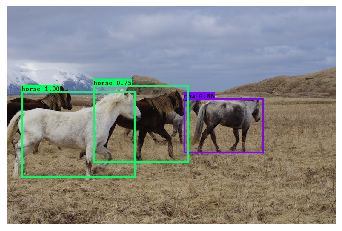

In [0]:
predict(sess, 'yolo/horses.jpg')

Time taken: 4.260356664657593 sec
Found 3 boxes for person.jpg
dog 0.99 (65, 257) (205, 341)
horse 0.87 (402, 135) (601, 337)
person 0.96 (191, 93) (268, 376)


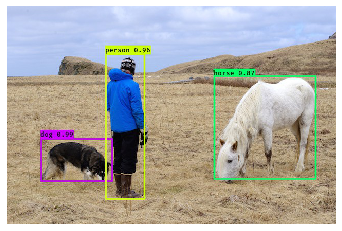

In [0]:
predict(sess, 'yolo/person.jpg')

Time taken: 6.158322095870972 sec
Found 2 boxes for two_dogs.jpg
dog 0.99 (38, 60) (321, 491)
dog 0.86 (558, 173) (1012, 553)


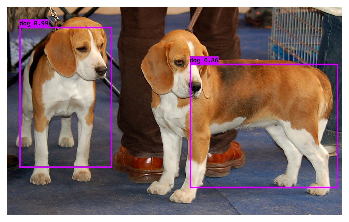

In [0]:
predict(sess, 'yolo/two_dogs.jpg')

Time taken: 7.140886068344116 sec
Found 6 boxes for beach.jpg
bird 0.77 (1078, 389) (1094, 423)
bird 0.64 (572, 339) (599, 373)
person 1.00 (114, 606) (163, 763)
person 0.98 (215, 696) (270, 853)
person 0.95 (82, 502) (103, 566)
person 0.75 (39, 510) (53, 554)


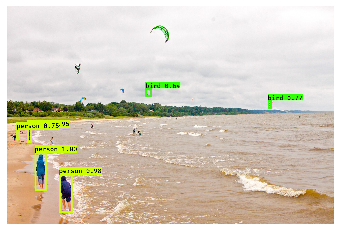

In [0]:
predict(sess, 'yolo/beach.jpg')